In [39]:
import os, re

BASE = "/Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder"

FOLDERS = {
    "physics_chapters":   f"{BASE}/physics_chapters_cleaned",
    "physics_pages":      f"{BASE}/physics_pages",
    "chemistry_chapters": f"{BASE}/chemistry_chapters_cleaned",
    "chemistry_pages":    f"{BASE}/chemistry_pages",
    "biology_chapters":   f"{BASE}/biology_chapters_cleaned",
    "biology_pages":      f"{BASE}/biology_pages",
}

FORMULA_RE = re.compile(r"\$\$(.*?)\$\$", flags=re.DOTALL)

def strip_formulas(text: str) -> str:
    return FORMULA_RE.sub(" ", text)

documents = {}
for label, folder in FOLDERS.items():
    if not os.path.isdir(folder):
        print(f"[WARN] Missing folder: {folder}")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".md"):
            path = os.path.join(folder, fname)
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                raw = f.read()
            documents[f"{label}/{fname}"] = strip_formulas(raw).lower()

print(f"Loaded {len(documents)} files.")
list(documents.keys())[:5]


Loaded 4435 files.


['physics_chapters/chapter_01.md',
 'physics_chapters/chapter_02.md',
 'physics_chapters/chapter_03.md',
 'physics_chapters/chapter_04.md',
 'physics_chapters/chapter_05.md']

In [40]:

import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    nlp = spacy.blank("en")
    from spacy.lang.en.stop_words import STOP_WORDS
    nlp.Defaults.stop_words |= STOP_WORDS

nlp.max_length = max(getattr(nlp, "max_length", 1_000_000), 10_000_000)


In [41]:
from collections import Counter
from tqdm.auto import tqdm  

stats = {}
names = list(documents.keys())
texts = [documents[n] for n in names]

DISABLE = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"] 
BATCH = 100

for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE)),
    total=len(names), desc="Token stats", smoothing=0.1
):
    toks_all = [t.text for t in doc if not t.is_space]   
    toks_no_stop = [t.text for t in doc if t.is_alpha and not t.is_stop]

    stats[name] = {
        "total_tokens": len(toks_all),
        "unique_tokens": len(set(toks_all)),
        "total_no_stop": len(toks_no_stop),
        "unique_no_stop": len(set(toks_no_stop)),
    }
next(iter(stats.items()))


Token stats: 100%|██████████| 4435/4435 [02:40<00:00, 27.60it/s]


('physics_chapters/chapter_01.md',
 {'total_tokens': 16670,
  'unique_tokens': 2612,
  'total_no_stop': 6477,
  'unique_no_stop': 1996})

In [42]:
# Builds a DTM (rows=docs, cols=terms) from content tokens; toggle lemmas for better matching across word forms.

import pandas as pd
from collections import Counter

USE_LEMMAS = False  # True → use t.lemma_ (requires lemmatizer); False → use t.text (faster)

DISABLE_DTM = ["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"]

term_counts = {}
for name, doc in tqdm(
    zip(names, nlp.pipe(texts, batch_size=BATCH, disable=DISABLE_DTM)),
    total=len(names), desc=f"DTM ({'lemmas' if USE_LEMMAS else 'tokens'})", smoothing=0.1
):
    toks = [t.text   for t in doc if t.is_alpha and not t.is_stop]
    term_counts[name] = Counter(toks)

dtm = pd.DataFrame.from_dict(term_counts, orient="index").fillna(0).astype(int)
dtm = dtm.reindex(sorted(dtm.columns), axis=1).fillna(0).astype(int)

dtm.shape, dtm.iloc[:3, :8]

DTM (tokens): 100%|██████████| 4435/4435 [02:36<00:00, 28.29it/s]


((4368, 29363),
                                 aa  aaa  aabb  aabbcc  aacc  aag  aand  aany
 physics_chapters/chapter_01.md   0    0     0       0     0    0     0     0
 physics_chapters/chapter_02.md   0    0     0       0     0    0     0     0
 physics_chapters/chapter_03.md   0    0     0       0     0    0     0     0)

In [43]:
import os
out_dir = os.path.join(BASE, "_outputs"); os.makedirs(out_dir, exist_ok=True)

In [44]:
import numpy as np

doc_names = list(dtm.index)
doc_sets = {d: set(term_counts[d].keys()) for d in doc_names}

n = len(doc_names)
jaccard = np.zeros((n, n), dtype=float)
for i in range(n):
    A = doc_sets[doc_names[i]]
    for j in range(n):
        B = doc_sets[doc_names[j]]
        jaccard[i, j] = 100.0 * len(A & B) / len(A | B) if (A or B) else 0.0

jaccard_df = pd.DataFrame(jaccard, index=doc_names, columns=doc_names)
jaccard_df.round(1).iloc[:8, :8]


,physics_chapters/chapter_01.md,physics_chapters/chapter_02.md,physics_chapters/chapter_03.md,physics_chapters/chapter_04.md,physics_chapters/chapter_05.md,physics_chapters/chapter_06.md,physics_chapters/chapter_07.md,physics_chapters/chapter_08.md
physics_chapters/chapter_01.md,100.0,25.0,21.7,26.7,21.4,25.7,23.9,22.0
physics_chapters/chapter_02.md,25.0,100.0,32.0,31.0,25.3,28.1,28.8,29.3
physics_chapters/chapter_03.md,21.7,32.0,100.0,27.4,23.2,27.3,23.6,28.0
physics_chapters/chapter_04.md,26.7,31.0,27.4,100.0,27.9,31.6,28.8,30.6
physics_chapters/chapter_05.md,21.4,25.3,23.2,27.9,100.0,26.3,26.5,25.0
physics_chapters/chapter_06.md,25.7,28.1,27.3,31.6,26.3,100.0,27.2,27.9
physics_chapters/chapter_07.md,23.9,28.8,23.6,28.8,26.5,27.2,100.0,28.1
physics_chapters/chapter_08.md,22.0,29.3,28.0,30.6,25.0,27.9,28.1,100.0


In [45]:
corr_df = dtm.T.corr(method="pearson") * 100.0
corr_df.round(1).iloc[:8, :8]

#taking too much time so finding cosine similarity would be better, if still needed i will do in end

,physics_chapters/chapter_01.md,physics_chapters/chapter_02.md,physics_chapters/chapter_03.md,physics_chapters/chapter_04.md,physics_chapters/chapter_05.md,physics_chapters/chapter_06.md,physics_chapters/chapter_07.md,physics_chapters/chapter_08.md
physics_chapters/chapter_01.md,100.0,29.2,20.7,28.1,24.2,30.6,19.1,24.1
physics_chapters/chapter_02.md,29.2,100.0,57.3,32.2,31.2,46.1,18.9,41.2
physics_chapters/chapter_03.md,20.7,57.3,100.0,31.9,28.5,35.6,15.7,34.6
physics_chapters/chapter_04.md,28.1,32.2,31.9,100.0,67.9,65.4,33.6,45.0
physics_chapters/chapter_05.md,24.2,31.2,28.5,67.9,100.0,54.3,31.7,39.7
physics_chapters/chapter_06.md,30.6,46.1,35.6,65.4,54.3,100.0,27.5,43.6
physics_chapters/chapter_07.md,19.1,18.9,15.7,33.6,31.7,27.5,100.0,40.7
physics_chapters/chapter_08.md,24.1,41.2,34.6,45.0,39.7,43.6,40.7,100.0


In [46]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

docs_order = list(term_counts.keys())
corpus_for_tfidf = [" ".join([tok for tok, c in term_counts[name].items() for _ in range(c)])
                    for name in docs_order]

tfidf = TfidfVectorizer(lowercase=False, token_pattern=r"(?u)\b\w+\b")
X_tfidf = tfidf.fit_transform(corpus_for_tfidf)
n = X_tfidf.shape[0]
sim = np.zeros((n, n), dtype=np.float32)
tile = 500 

pbar = tqdm(total=n, desc="Cosine TF-IDF tiles")
start = 0
while start < n:
    end = min(start + tile, n)
    block = cosine_similarity(X_tfidf[start:end], X_tfidf)
    sim[start:end, :] = block.astype(np.float32) * 100.0
    start = end
    pbar.update(block.shape[0])
pbar.close()

cosine_df = pd.DataFrame(sim, index=docs_order, columns=docs_order)
cosine_df.iloc[:8, :8].round(1)


Cosine TF-IDF tiles: 100%|██████████| 4435/4435 [00:00<00:00, 12077.88it/s]


,physics_chapters/chapter_01.md,physics_chapters/chapter_02.md,physics_chapters/chapter_03.md,physics_chapters/chapter_04.md,physics_chapters/chapter_05.md,physics_chapters/chapter_06.md,physics_chapters/chapter_07.md,physics_chapters/chapter_08.md
physics_chapters/chapter_01.md,100.000000,20.900000,13.500000,22.500000,16.400000,21.799999,16.799999,15.300000
physics_chapters/chapter_02.md,20.900000,100.000000,48.900002,31.799999,25.100000,39.799999,20.700001,33.500000
physics_chapters/chapter_03.md,13.500000,48.900002,100.000000,27.799999,19.900000,26.400000,15.400000,26.700001
physics_chapters/chapter_04.md,22.500000,31.799999,27.799999,100.000000,53.900002,52.900002,35.500000,35.099998
physics_chapters/chapter_05.md,16.400000,25.100000,19.900000,53.900002,100.000000,37.200001,31.500000,26.900000
physics_chapters/chapter_06.md,21.799999,39.799999,26.400000,52.900002,37.200001,100.000000,25.400000,30.400000
physics_chapters/chapter_07.md,16.799999,20.700001,15.400000,35.500000,31.500000,25.400000,100.000000,31.100000
physics_chapters/chapter_08.md,15.300000,33.500000,26.700001,35.099998,26.900000,30.400000,31.100000,100.000000


In [47]:
# Saves stats, DTM, and whichever similarity matrix you actually computed (corr_df or cosine_df).

import os
out_dir = os.path.join(BASE, "_outputs")
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame.from_dict(stats, orient="index").to_csv(os.path.join(out_dir, "token_stats.csv"))
dtm.to_csv(os.path.join(out_dir, "dtm_counts.csv"))

saved_any_similarity = False


if "corr_df" in globals():
    corr_df.to_csv(os.path.join(out_dir, "pearson_corr_percent.csv"))
    print("Saved Pearson correlation → pearson_corr_percent.csv")
    saved_any_similarity = True


if "cosine_df" in globals():
    cosine_df.to_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"))
    print("Saved cosine TF-IDF similarity → cosine_tfidf_percent.csv")
    saved_any_similarity = True


if "jaccard_df" in globals():
    jaccard_df.to_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"))
    print("Saved Jaccard overlap → jaccard_overlap_percent.csv")

print("Saved to:", out_dir)

Saved Pearson correlation → pearson_corr_percent.csv
Saved cosine TF-IDF similarity → cosine_tfidf_percent.csv
Saved Jaccard overlap → jaccard_overlap_percent.csv
Saved to: /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs


Visualization

In [48]:
# Imports seaborn/matplotlib and defines a helper to plot & save big matrices nicely.

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title, out_name, vmin=None, vmax=None, cmap="viridis", annotate=False):
    plt.figure(figsize=(10, 8))  # grow if you need more resolution
    ax = sns.heatmap(
        df, vmin=vmin, vmax=vmax, cmap=cmap,
        square=True, cbar=True, xticklabels=False, yticklabels=False,
        annot=annotate, fmt=".1f"
    )
    ax.set_title(title)
    plt.tight_layout()

    out_dir = os.path.join(BASE, "_outputs")
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, out_name)
    plt.savefig(path, dpi=300)
    plt.show()
    print("Saved figure →", path)


In [49]:
# Reads the matrices you saved so plots are reproducible even in a fresh session.

out_dir = os.path.join(BASE, "_outputs")
jaccard_df = pd.read_csv(os.path.join(out_dir, "jaccard_overlap_percent.csv"), index_col=0)
cosine_df  = pd.read_csv(os.path.join(out_dir, "cosine_tfidf_percent.csv"), index_col=0)
print(jaccard_df.shape, cosine_df.shape)


(4368, 4368) (4435, 4435)


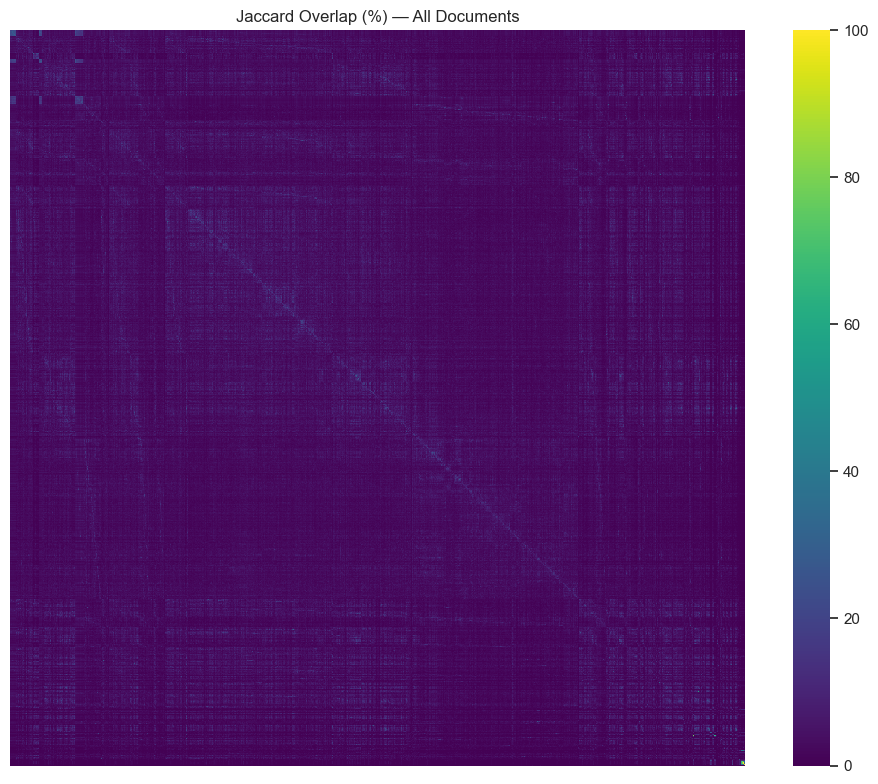

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_all.png


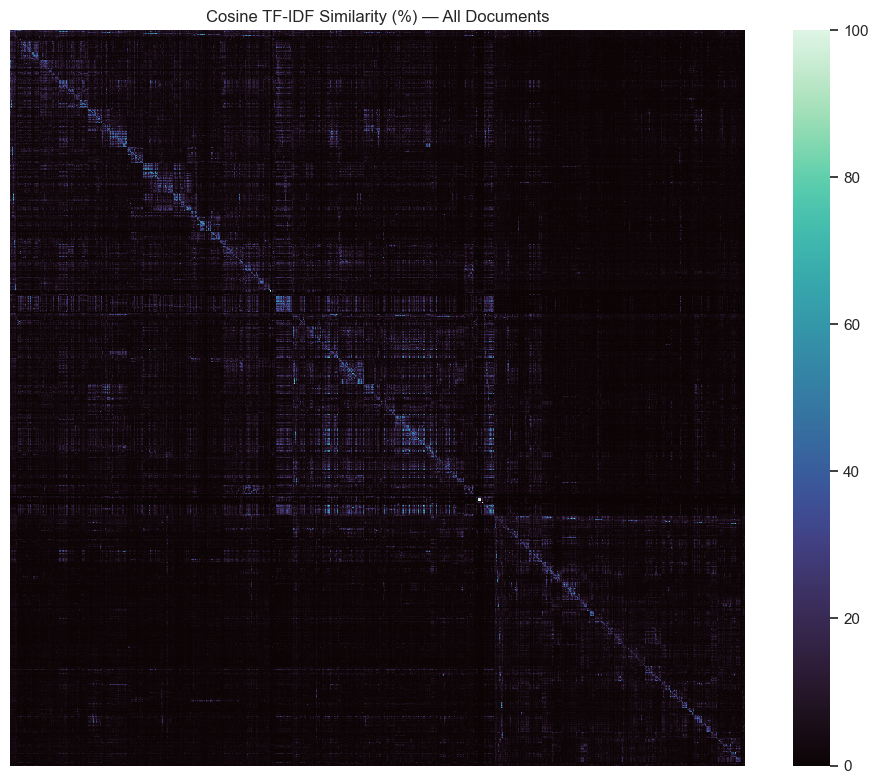

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_all.png


In [50]:
# Plots full heatmaps; for very large matrices, hide tick labels to keep rendering fast.

plot_heatmap(
    jaccard_df,
    title="Jaccard Overlap (%) — All Documents",
    out_name="heatmap_jaccard_all.png",
    vmin=0, vmax=100, cmap="viridis", annotate=False
)

plot_heatmap(
    cosine_df,
    title="Cosine TF-IDF Similarity (%) — All Documents",
    out_name="heatmap_cosine_all.png",
    vmin=0, vmax=100, cmap="mako", annotate=False
)


In [51]:
# Slices matrices by prefix to visualize specific groups (intrabook) or cross-groups (interbook).

def rows_with_prefix(df, prefix):
    return [i for i in df.index if i.startswith(prefix)]

phys_chap = rows_with_prefix(jaccard_df, "physics_chapters/")
bio_chap = rows_with_prefix(jaccard_df, "chemistry_chapters/")
chem_chap = rows_with_prefix(jaccard_df, "biology_chapters/")
phys_pages = rows_with_prefix(jaccard_df, "physics_pages/")
bio_pages = rows_with_prefix(jaccard_df, "biology_pages/")
chem_pages = rows_with_prefix(jaccard_df, "chemistry_pages/")



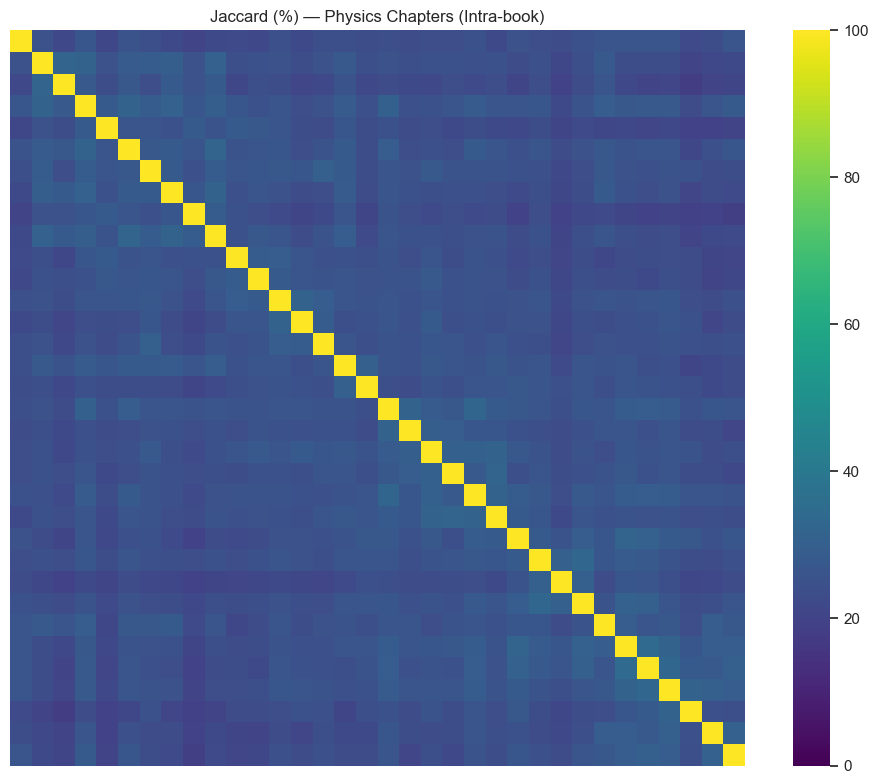

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physics_chapters.png


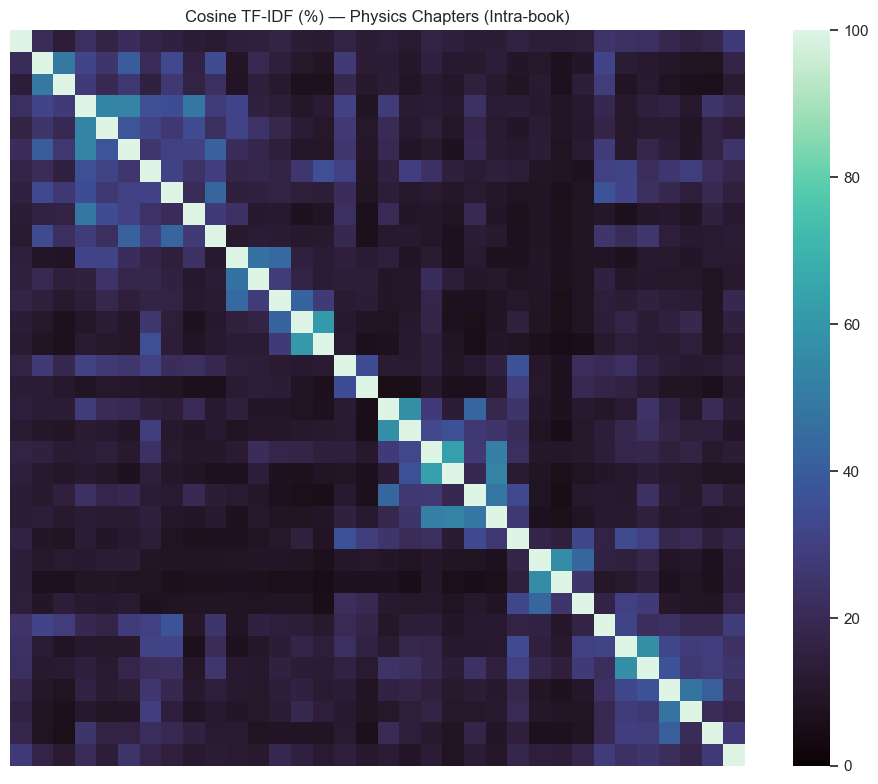

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_physics_chapters.png


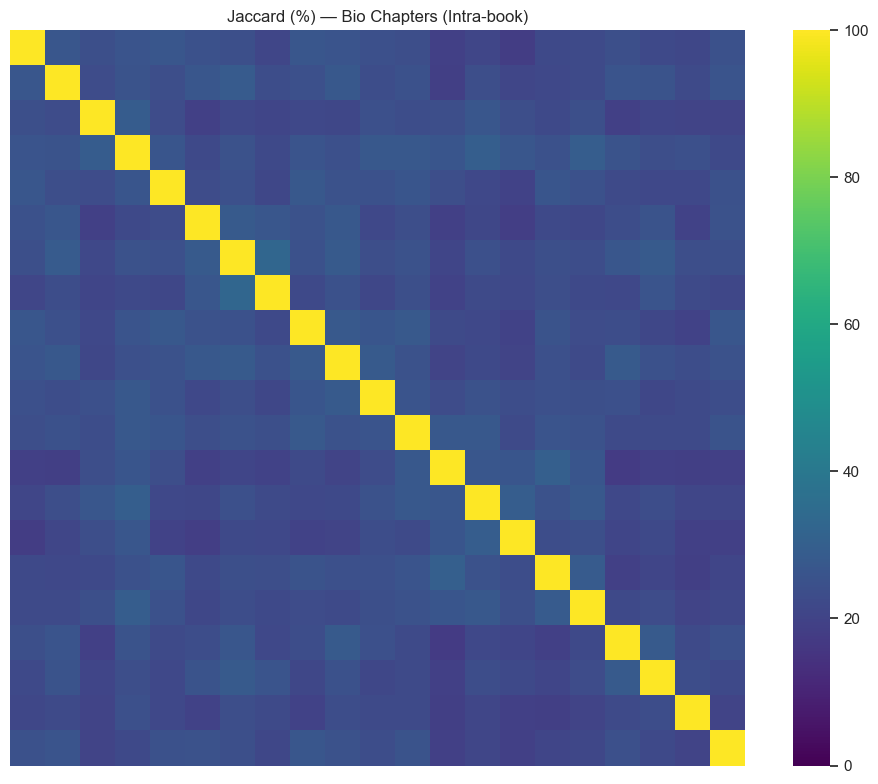

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_biology_chapters.png


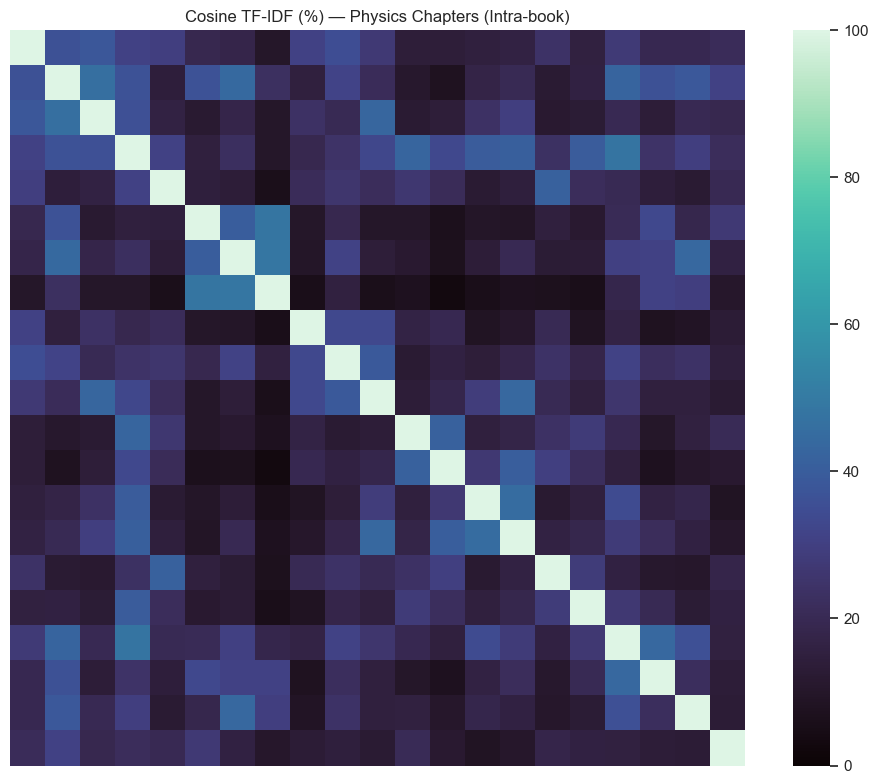

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_biology_chapters.png


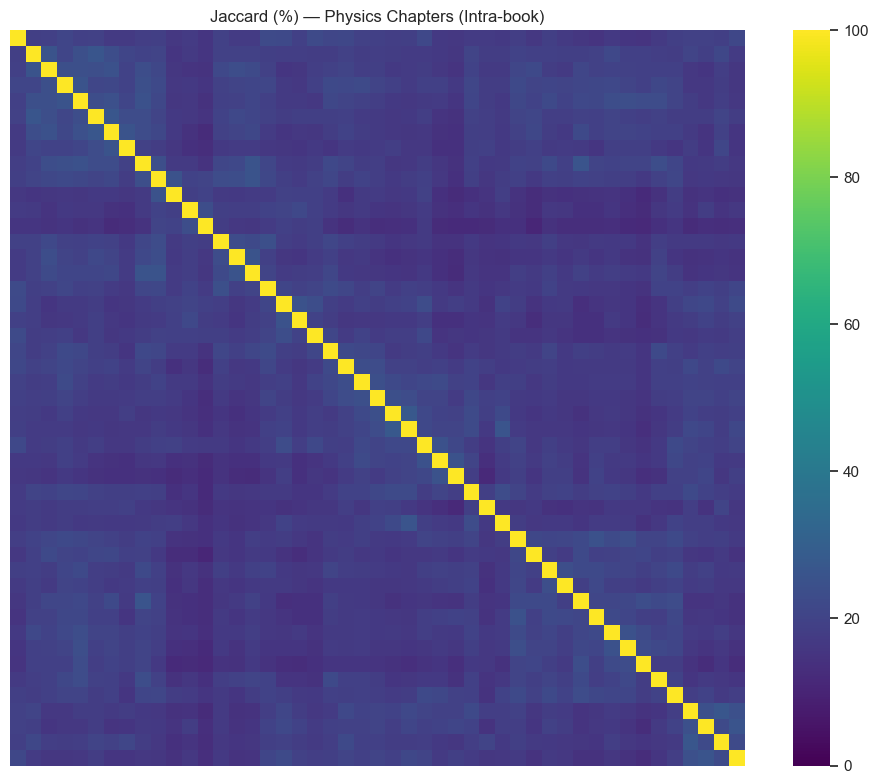

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemistry_chapters.png


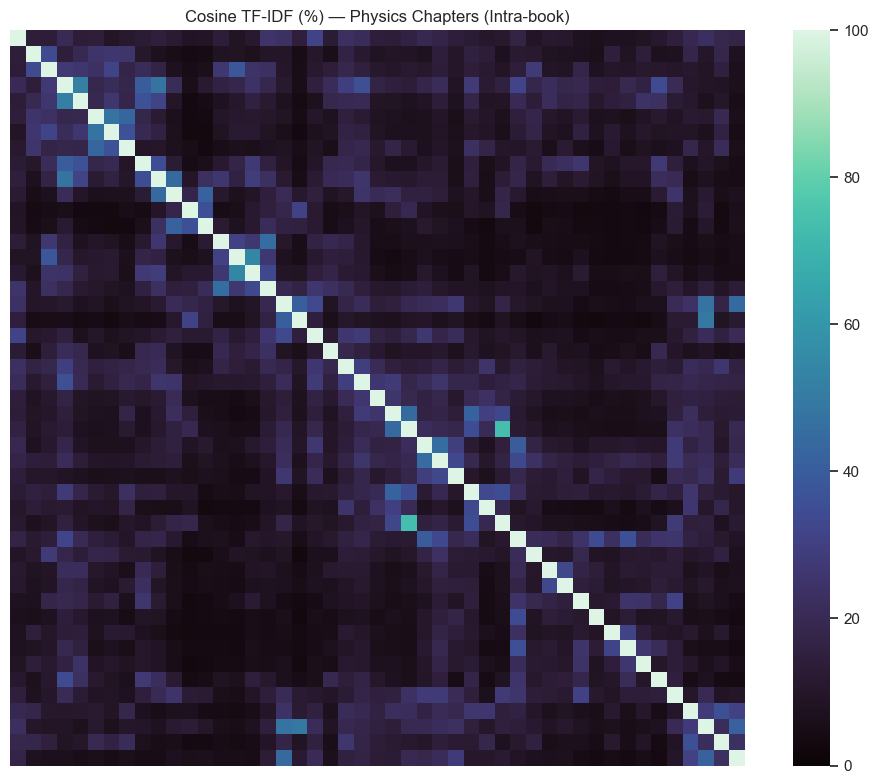

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_chemistry_chapters.png


In [52]:

# Intrabook: physics chapters only
plot_heatmap(
    jaccard_df.loc[phys_chap, phys_chap],
    title="Jaccard (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_jaccard_physics_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[phys_chap, phys_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_physics_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: biology chapters only
plot_heatmap(
    jaccard_df.loc[bio_chap, bio_chap],
    title="Jaccard (%) — Bio Chapters (Intra-book)",
    out_name="heatmap_jaccard_biology_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[bio_chap, bio_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_biology_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)


# Intrabook: chemistry chapters only
plot_heatmap(
    jaccard_df.loc[chem_chap, chem_chap],
    title="Jaccard (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_jaccard_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="viridis"
)

plot_heatmap(
    cosine_df.loc[chem_chap, chem_chap],
    title="Cosine TF-IDF (%) — Physics Chapters (Intra-book)",
    out_name="heatmap_cosine_chemistry_chapters.png",
    vmin=0, vmax=100, cmap="mako"
)

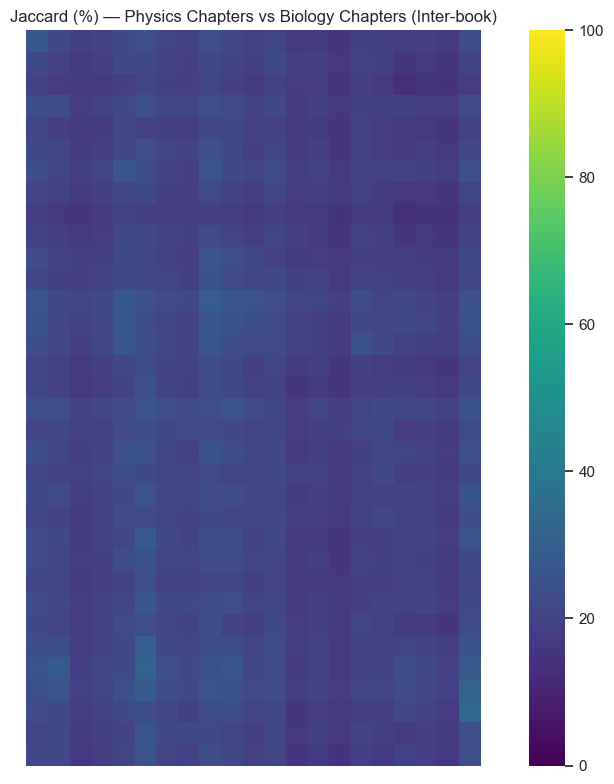

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_bio_chap.png


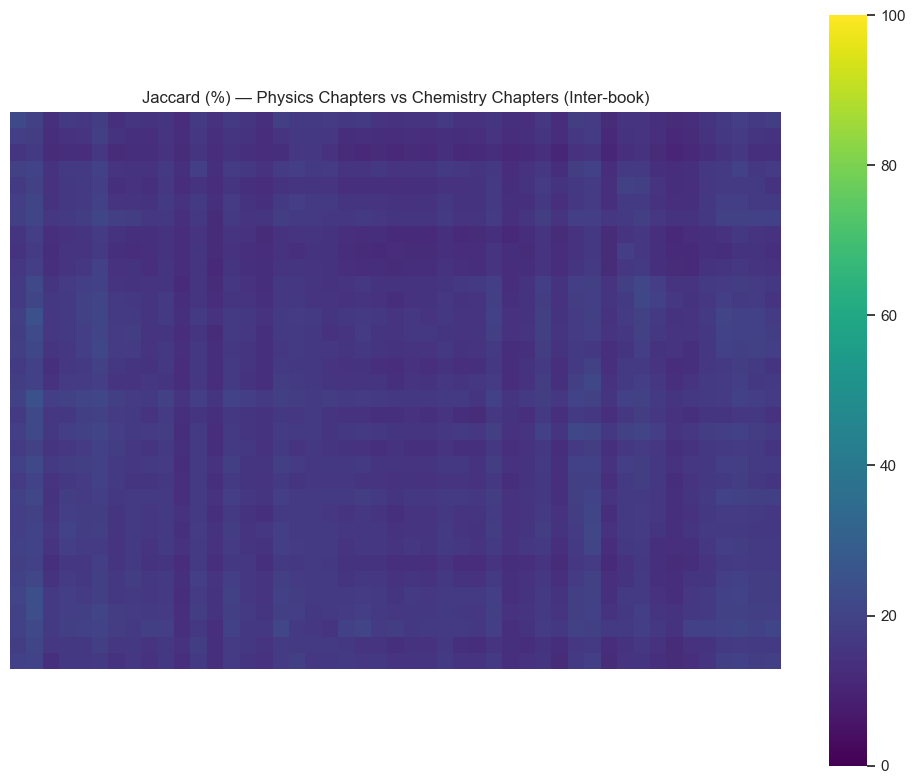

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_physchap_vs_chem_chap.png


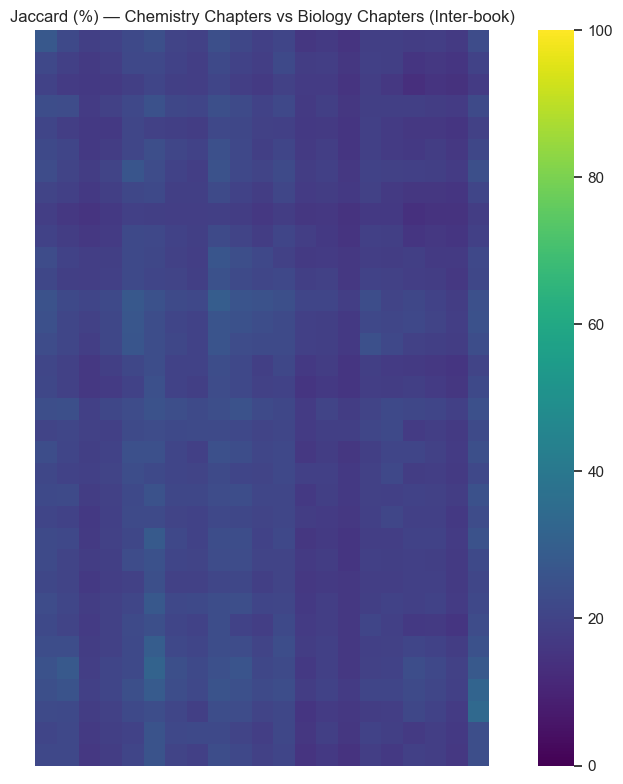

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_jaccard_chemchap_vs_bio_chap.png


In [53]:
# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Physics Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, chem_chap],
    title="Jaccard (%) — Physics Chapters vs Chemistry Chapters (Inter-book)",
    out_name="heatmap_jaccard_physchap_vs_chem_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

# Interbook: physics chapters vs biology pages
plot_heatmap(
    jaccard_df.loc[phys_chap, bio_chap],
    title="Jaccard (%) — Chemistry Chapters vs Biology Chapters (Inter-book)",
    out_name="heatmap_jaccard_chemchap_vs_bio_chap.png",
    vmin=0, vmax=100, cmap="viridis"
)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


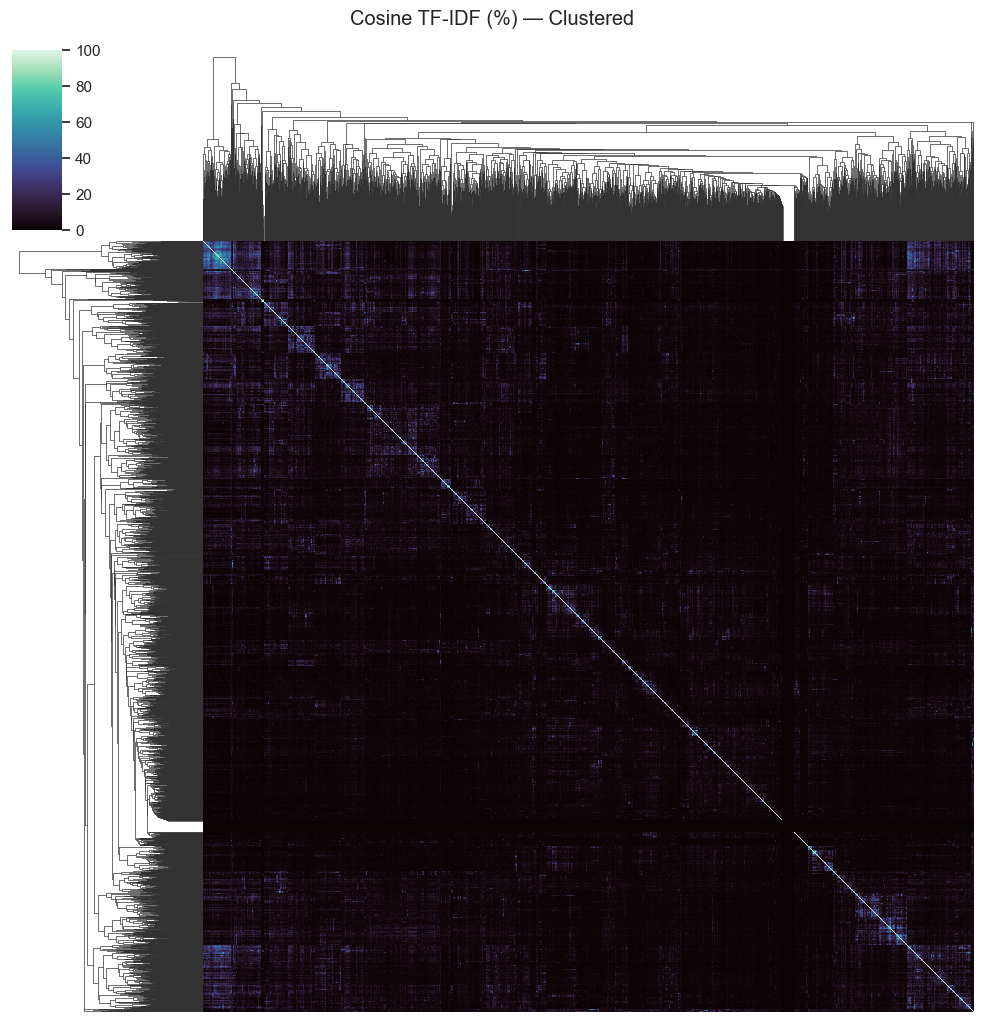

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/clustermap_cosine_all.png


In [54]:

sns.set(context="notebook")
g = sns.clustermap(
    cosine_df, cmap="mako", figsize=(10, 10),
    row_cluster=True, col_cluster=True,
    xticklabels=False, yticklabels=False
)
g.fig.suptitle("Cosine TF-IDF (%) — Clustered", y=1.02)
out_path = os.path.join(BASE, "_outputs", "clustermap_cosine_all.png")
g.savefig(out_path, dpi=300)
plt.show()
print("Saved figure →", out_path)


In [55]:

def top_k_neighbors(sim_df, k=5):
    rows = []
    for i, row in sim_df.iterrows():
        # drop self-similarity then take top-k
        sr = row.drop(labels=[i], errors="ignore").sort_values(ascending=False).head(k)
        for j, val in sr.items():
            rows.append({"doc": i, "neighbor": j, "score_percent": round(float(val), 2)})
    return pd.DataFrame(rows)

nn_cosine = top_k_neighbors(cosine_df, k=5)
nn_jaccard = top_k_neighbors(jaccard_df, k=5)

nn_cosine.head(10)
nn_cosine.tail(10)


,doc,neighbor,score_percent
22165,biology_pages/page_1486.md,biology_pages/page_0458.md,15.64
22166,biology_pages/page_1486.md,biology_pages/page_0443.md,15.53
22167,biology_pages/page_1486.md,biology_chapters/chapter_16.md,15.26
22168,biology_pages/page_1486.md,biology_pages/page_0457.md,13.02
22169,biology_pages/page_1486.md,biology_pages/page_1336.md,12.06
22170,biology_pages/page_1487.md,biology_pages/page_0711.md,15.79
22171,biology_pages/page_1487.md,biology_pages/page_0720.md,15.37
22172,biology_pages/page_1487.md,biology_pages/page_0719.md,14.93
22173,biology_pages/page_1487.md,biology_pages/page_0893.md,14.77
22174,biology_pages/page_1487.md,biology_pages/page_0889.md,14.01


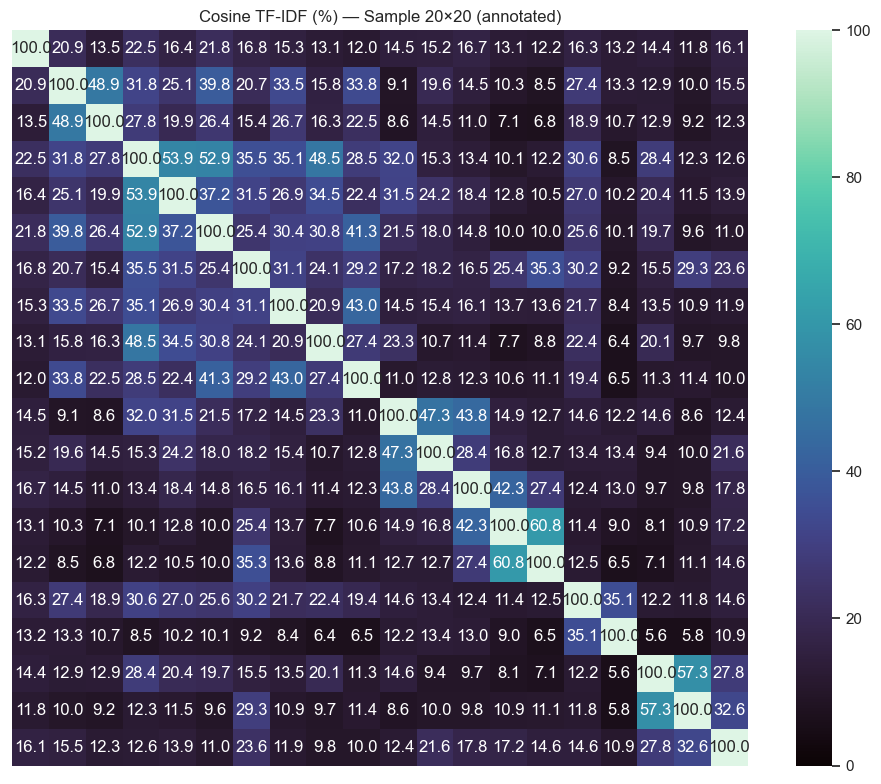

Saved figure → /Users/tanmayagarwal/Desktop/My_Computer/Columbia/Fall_2025/RA_LLM/main_folder/_outputs/heatmap_cosine_sample_annot.png


In [56]:
# For small subsets (e.g., 20x20).

subset = cosine_df.iloc[:20, :20]
plot_heatmap(
    subset,
    title="Cosine TF-IDF (%) — Sample 20×20 (annotated)",
    out_name="heatmap_cosine_sample_annot.png",
    vmin=0, vmax=100, cmap="mako", annotate=True
)
